In [3]:
# Install necessary libraries
!pip install optuna --quiet
!pip install imbalanced-learn --quiet
!pip install xgboost --upgrade --quiet
!pip install scikit-learn --quiet


!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d patrickzel/flight-delay-and-cancellation-dataset-2019-2023

!unzip flight-delay-and-cancellation-dataset-2019-2023.zip



Dataset URL: https://www.kaggle.com/datasets/patrickzel/flight-delay-and-cancellation-dataset-2019-2023
License(s): other
Archive:  flight-delay-and-cancellation-dataset-2019-2023.zip
  inflating: dictionary.html         
  inflating: flights_sample_3m.csv   


In [70]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv('/content/flights_sample_3m.csv')  # adjust path if needed

# Subset data to 1 million rows for manageable training
df = df.sample(n=1000000, random_state=42).reset_index(drop=True)

# Important columns to check for missingness
important_cols = ['FL_DATE', 'AIRLINE', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DISTANCE']

# Drop rows where important features are missing
df = df.dropna(subset=important_cols)

print(f"Dataset shape after cleaning important columns: {df.shape}")


Dataset shape after cleaning important columns: (1000000, 32)


In [71]:
import numpy as np

# Cap extreme ARR_DELAY values at the 1st and 99th percentiles
lower_bound = np.percentile(df['ARR_DELAY'].dropna(), 1)
upper_bound = np.percentile(df['ARR_DELAY'].dropna(), 99)

# Winsorize
df['ARR_DELAY'] = np.clip(df['ARR_DELAY'], lower_bound, upper_bound)

print(f"✅ ARR_DELAY winsorized: values capped between {lower_bound:.2f} and {upper_bound:.2f}")


✅ ARR_DELAY winsorized: values capped between -37.00 and 190.00


In [72]:
# Create Arrival Delay Target
df['IS_ARRIVAL_DELAYED'] = (df['ARR_DELAY'] > 15).astype(int)

print("Target variable distribution:")
print(df['IS_ARRIVAL_DELAYED'].value_counts())


Target variable distribution:
IS_ARRIVAL_DELAYED
0    827476
1    172524
Name: count, dtype: int64


In [73]:
# Leakage columns: anything that directly or indirectly gives away arrival delay
leakage_cols = [
    'ARR_TIME', 'ARR_DELAY', 'ELAPSED_TIME', 'AIR_TIME', 'TAXI_IN', 'WHEELS_ON',
    'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED','DELAY_DUE_LATE_AIRCRAFT', 'AIRLINE_DOT', 'AIRLINE_CODE',
    'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_SECURITY', 'DEP_DELAY']

df.drop(columns=[col for col in leakage_cols if col in df.columns], inplace=True)

print(f"Remaining columns: {df.columns.tolist()}")


Remaining columns: ['FL_DATE', 'AIRLINE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_TIME', 'TAXI_OUT', 'WHEELS_OFF', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'IS_ARRIVAL_DELAYED']


In [74]:
# Time features
df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100
df['CRS_DEP_MINUTE'] = df['CRS_DEP_TIME'] % 100
df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100
df['CRS_ARR_MINUTE'] = df['CRS_ARR_TIME'] % 100

# Date features
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
df['MONTH'] = df['FL_DATE'].dt.month
df['DAY'] = df['FL_DATE'].dt.day

# Distance bins
df['DISTANCE_BIN'] = pd.qcut(df['DISTANCE'], q=5, labels=False)

# Drop original CRS_DEP_TIME, CRS_ARR_TIME, FL_DATE, and raw DISTANCE (after feature engineering)
df.drop(['CRS_DEP_TIME', 'CRS_ARR_TIME', 'FL_DATE', 'DISTANCE'], axis=1, inplace=True)

print(f"Final dataset shape after feature engineering: {df.shape}")


Final dataset shape after feature engineering: (1000000, 20)


In [75]:
from sklearn.preprocessing import LabelEncoder

# Encode object type columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

le_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    le_encoders[col] = le

print(f"Categorical columns encoded: {categorical_cols}")


Categorical columns encoded: ['AIRLINE', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY']


In [76]:
X = df.drop(columns=['IS_ARRIVAL_DELAYED'])
y = df['IS_ARRIVAL_DELAYED']

print(f"Features shape: {X.shape}, Target shape: {y.shape}")


Features shape: (1000000, 19), Target shape: (1000000,)


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (800000, 19), Test set: (200000, 19)


In [78]:
from sklearn.impute import SimpleImputer

# Separate numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

# Impute numeric columns
num_imputer = SimpleImputer(strategy='mean')
X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])

print("Missing values imputed")


Missing values imputed


In [79]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(f"Balanced training set shape: {X_train_bal.shape}, {y_train_bal.shape}")
print("Balanced class distribution:")
print(pd.Series(y_train_bal).value_counts())


Balanced training set shape: (1323962, 19), (1323962,)
Balanced class distribution:
IS_ARRIVAL_DELAYED
0    661981
1    661981
Name: count, dtype: int64


In [80]:
import xgboost as xgb

tree_method = 'hist'

In [81]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 2.0),
        'tree_method': tree_method,
        'objective': 'binary:logistic',
        'random_state': 42,
        'eval_metric': 'logloss',
        'device' : 'cuda'
    }

    model = xgb.XGBClassifier(**params)
    score = cross_val_score(model, X_train_bal, y_train_bal, cv=3, scoring=make_scorer(f1_score)).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters found:")
print(study.best_params)


[I 2025-04-26 20:58:10,290] A new study created in memory with name: no-name-73c24da1-d7dc-45c9-9a35-ef448f2eabd0
[I 2025-04-26 20:58:24,096] Trial 0 finished with value: 0.9192580288162323 and parameters: {'max_depth': 8, 'learning_rate': 0.21642671225894766, 'n_estimators': 894, 'gamma': 0.12665294306655375, 'min_child_weight': 8, 'subsample': 0.948619812290624, 'colsample_bytree': 0.8641640404729913, 'scale_pos_weight': 1.3525029787174778}. Best is trial 0 with value: 0.9192580288162323.
[I 2025-04-26 20:58:36,077] Trial 1 finished with value: 0.9241783182017063 and parameters: {'max_depth': 12, 'learning_rate': 0.15717603768315266, 'n_estimators': 209, 'gamma': 0.372611656119412, 'min_child_weight': 1, 'subsample': 0.7211003496152015, 'colsample_bytree': 0.7524451909133724, 'scale_pos_weight': 1.336535447682893}. Best is trial 1 with value: 0.9241783182017063.
[I 2025-04-26 20:58:44,215] Trial 2 finished with value: 0.8998283426836823 and parameters: {'max_depth': 6, 'learning_rate

Best hyperparameters found:
{'max_depth': 11, 'learning_rate': 0.13913855739990832, 'n_estimators': 282, 'gamma': 0.9293159947297213, 'min_child_weight': 2, 'subsample': 0.6560106352351653, 'colsample_bytree': 0.8862451575709467, 'scale_pos_weight': 1.643180925277964}


In [82]:
# Train best model
best_params = study.best_params
best_params.update({
    'tree_method': tree_method,
    'objective': 'binary:logistic',
    'random_state': 42,
    'eval_metric': 'logloss',
    'device': 'cuda'
})

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_bal, y_train_bal)

print("Final XGBoost model trained!")


Final XGBoost model trained!


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    165495
           1       0.87      0.83      0.85     34505

    accuracy                           0.95    200000
   macro avg       0.92      0.90      0.91    200000
weighted avg       0.95      0.95      0.95    200000

ROC-AUC Score: 0.9651910120437648
PR-AUC Score: 0.9159581776606489


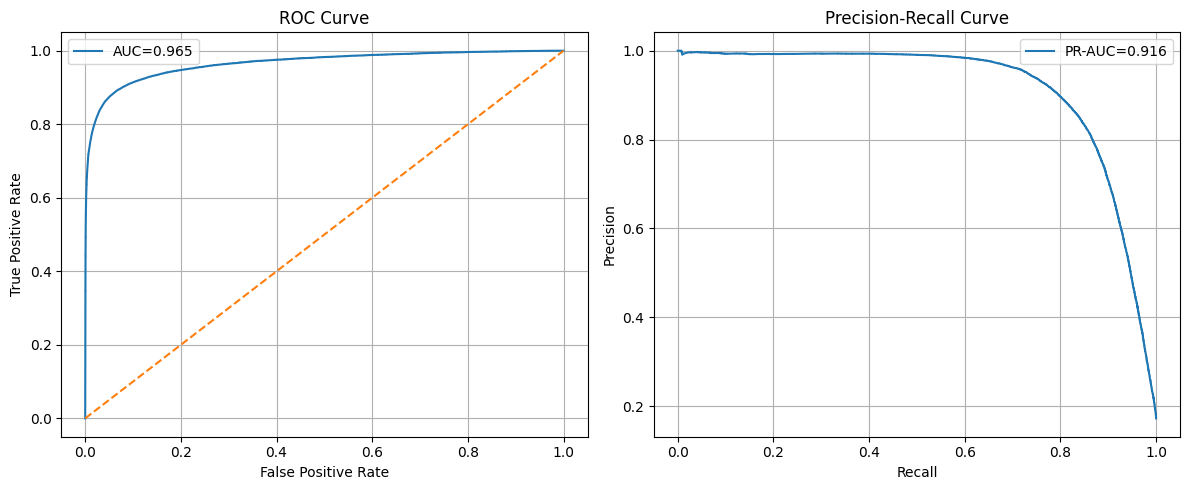

In [83]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("PR-AUC Score:", average_precision_score(y_test, y_pred_proba))

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label=f'PR-AUC={pr_auc:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()

# Show both plots
plt.tight_layout()
plt.show()

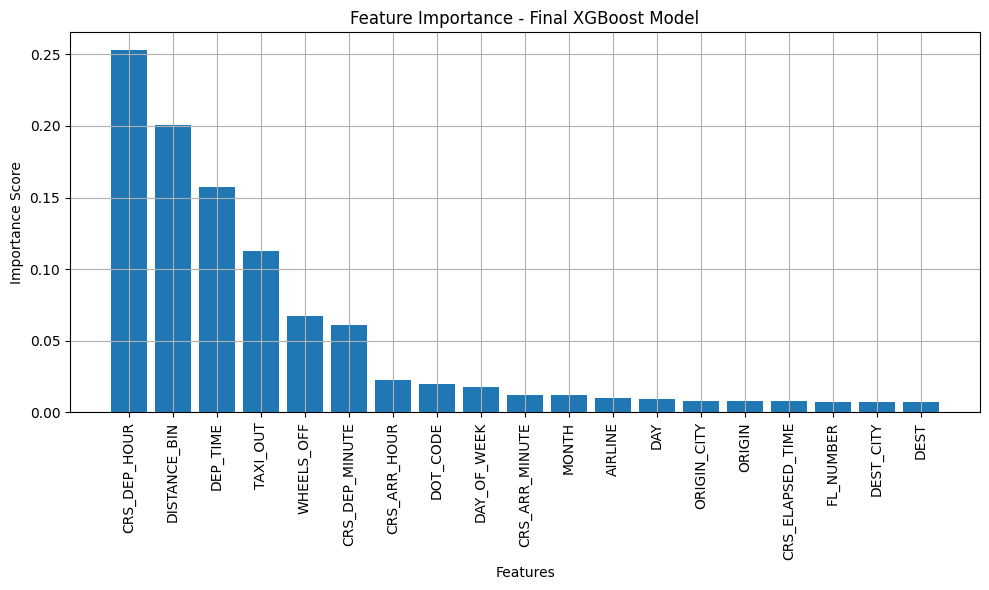

In [84]:
# Plot feature importance
import matplotlib.pyplot as plt
importances = final_model.feature_importances_
features = X_train.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Final XGBoost Model")
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), features[indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.grid(True)
plt.show()


In [85]:
# Predict on test set
test_predictions = final_model.predict(X_test)
test_probabilities = final_model.predict_proba(X_test)[:, 1]

# Create output dataframe
output_df = X_test.copy()
output_df['TRUE_LABEL'] = y_test.values
output_df['PREDICTED_LABEL'] = test_predictions
output_df['PREDICTED_PROBABILITY'] = (test_probabilities * 100).round(2)

# Save to CSV
output_df.to_csv('arrival_delay_test_predictions.csv', index=False)

print("Test set predictions saved as 'arrival_delay_test_predictions.csv'!")


Test set predictions saved as 'arrival_delay_test_predictions.csv'!


In [86]:
import joblib

# Save the trained model
joblib.dump(final_model, 'arrival_delay_xgboost_model.pkl')

print("Final model saved successfully as 'arrival_delay_xgboost_model.pkl'!")


Final model saved successfully as 'arrival_delay_xgboost_model.pkl'!
